# Business Bankruptcy Prediction

#### Preface
Imbalanced classification problems are particularly challenging in data science due to the tendency of models to be rewarded for always predicting the majority class. This project examines three algorithms (logistic regression, naive Bayes, and classification trees) and compares them to the null of always predicting the majority class. Also examined is the ability of undersampling to improve models' precision and recall. The dataset used contains bankruptcy information for companies in Poland in which the overwhelming majority are not insolvent. 

### Data Acquisition and Preparation

#### Source 
Dataset was obtained from UCI Machine Learning Repository. Link:
https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data
<br/><br/>
#### Comments
**Summary from UCI:**

*The dataset is about bankruptcy prediction of Polish companies. The data was collected from Emerging Markets Information Service (EMIS), which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.
Basing on the collected data five classification cases were distinguished, that depends on the forecasting period:*
- *1stYear : the data contains financial rates from 1st year of the forecasting period and corresponding class label that indicates bankruptcy status after 5 years. The data contains 7027 instances (financial statements), 271 represents bankrupted companies, 6756 firms that did not bankrupt in the forecasting period.*
- *2ndYear : the data contains financial rates from 2nd year of the forecasting period and corresponding class label that indicates bankruptcy status after 4 years. The data contains 10173 instances (financial statements), 400 represents bankrupted companies, 9773 firms that did not bankrupt in the forecasting period.*
- *3rdYear : the data contains financial rates from 3rd year of the forecasting period and corresponding class label that indicates bankruptcy status after 3 years. The data contains 10503 instances (financial statements), 495 represents bankrupted companies, 10008 firms that did not bankrupt in the forecasting period.*
- *4thYear : the data contains financial rates from 4th year of the forecasting period and corresponding class label that indicates bankruptcy status after 2 years. The data contains 9792 instances (financial statements), 515 represents bankrupted companies, 9277 firms that did not bankrupt in the forecasting period.*
- *5thYear : the data contains financial rates from 5th year of the forecasting period and corresponding class label that indicates bankruptcy status after 1 year. The data contains 5910 instances (financial statements), 410 represents bankrupted companies, 5500 firms that did not bankrupt in the forecasting period.*

**Feature Description:**

- X1	net profit / total assets
- X2	total liabilities / total assets 
- X3	working capital / total assets 
- X4	current assets / short-term liabilities 
- X5	[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 
- X6	retained earnings / total assets 
- X7	EBIT / total assets 
- X8	book value of equity / total liabilities 
- X9	sales / total assets 
- X10	equity / total assets 
- X11	(gross profit + extraordinary items + financial expenses) / total assets 
- X12	gross profit / short-term liabilities 
- X13	(gross profit + depreciation) / sales 
- X14	(gross profit + interest) / total assets 
- X15	(total liabilities * 365) / (gross profit + depreciation) 
- X16	(gross profit + depreciation) / total liabilities 
- X17	total assets / total liabilities 
- X18	gross profit / total assets 
- X19	gross profit / sales 
- X20	(inventory * 365) / sales 
- X21	sales (n) / sales (n-1) 
- X22	profit on operating activities / total assets 
- X23	net profit / sales 
- X24	gross profit (in 3 years) / total assets 
- X25	(equity - share capital) / total assets 
- X26	(net profit + depreciation) / total liabilities 
- X27	profit on operating activities / financial expenses 
- X28	working capital / fixed assets 
- X29	logarithm of total assets 
- X30	(total liabilities - cash) / sales 
- X31	(gross profit + interest) / sales 
- X32	(current liabilities * 365) / cost of products sold 
- X33	operating expenses / short-term liabilities 
- X34	operating expenses / total liabilities 
- X35	profit on sales / total assets 
- X36	total sales / total assets 
- X37	(current assets - inventories) / long-term liabilities 
- X38	constant capital / total assets 
- X39	profit on sales / sales 
- X40	(current assets - inventory - receivables) / short-term liabilities 
- X41	total liabilities / ((profit on operating activities + depreciation) * (12/365)) 
- X42	profit on operating activities / sales 
- X43	rotation receivables + inventory turnover in days 
- X44	(receivables * 365) / sales 
- X45	net profit / inventory 
- X46	(current assets - inventory) / short-term liabilities 
- X47	(inventory * 365) / cost of products sold 
- X48	EBITDA (profit on operating activities - depreciation) / total assets 
- X49	EBITDA (profit on operating activities - depreciation) / sales 
- X50	current assets / total liabilities 
- X51	short-term liabilities / total assets 
- X52	(short-term liabilities * 365) / cost of products sold) 
- X53	equity / fixed assets 
- X54	constant capital / fixed assets 
- X55	working capital 
- X56	(sales - cost of products sold) / sales 
- X57	(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation) 
- X58	total costs /total sales 
- X59	long-term liabilities / equity 
- X60	sales / inventory 
- X61	sales / receivables 
- X62	(short-term liabilities *365) / sales 
- X63	sales / short-term liabilities 
- X64	sales / fixed assets



In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.arff import loadarff
%matplotlib inline

year_data = []
for i in range(1,6):
    i = str(i)
    file_name = i+'year.arff'
    year_data.append(loadarff(i+'year.arff'))

data = [pd.DataFrame.from_records(data=x[0]) for x in year_data]
company_data = pd.concat(data, axis=0) 
column_names = ['x'+str(i) for i in range(1,65)] + ['bankrupt']
column_names = {k:v for (k,v) in zip(company_data.columns, column_names)}
company_data.rename(columns=column_names, inplace=True)
company_data['bankrupt'] = company_data['bankrupt'].astype('int')
company_data.shape

nas_by_feature = company_data.isnull().sum(axis=0)
features_to_drop = nas_by_feature[nas_by_feature>2000].index
company_data.drop(features_to_drop, axis=1, inplace=True)
company_data.fillna(company_data.median(), inplace=True)

In [33]:
#preliminary = company_data.sample(n=3000)
#company_data = preliminary
company_data.shape

(43405, 60)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import RobustScaler

metrics = pd.DataFrame(index=['accuracy','precision','recall'], 
                      columns=['NULL', 'LogisticReg', 'ClassTree', 'NaiveBayes'])

target_name = 'bankrupt'
robust_scaler = RobustScaler()
X = company_data.drop('bankrupt', axis=1)
X = robust_scaler.fit_transform(X)
y = company_data[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

In [35]:
%%capture

y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(C=10, n_jobs=-1, random_state=15)

logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

from sklearn.tree import DecisionTreeClassifier

class_tree = DecisionTreeClassifier(max_depth=7, random_state=10)

class_tree.fit(X_train, y_train)

y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)

from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(X_train, y_train)
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

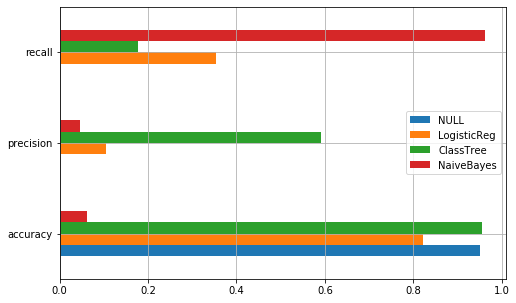

In [36]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [37]:
%%capture

negative_cases = company_data.loc[company_data['bankrupt']==0].sample(n=4000)
positive_cases = company_data.loc[company_data['bankrupt']==1]
company_data = pd.concat([negative_cases, positive_cases])

target_name = 'bankrupt'
robust_scaler = RobustScaler()
X = company_data.drop('bankrupt', axis=1)
X = robust_scaler.fit_transform(X)
y = company_data[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=125, stratify=y)

y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(C=10, n_jobs=-1, random_state=15)

logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

from sklearn.tree import DecisionTreeClassifier

class_tree = DecisionTreeClassifier(max_depth=7, random_state=10)

class_tree.fit(X_train, y_train)

y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)

from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(X_train, y_train)
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

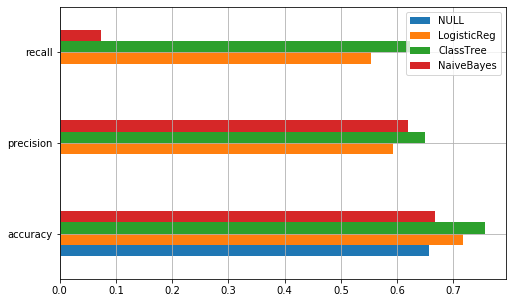

In [38]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

### Conclusion 
As expected, all of the models performed poorly when trained on the entire dataset due to the disproportionate influence of non-bankrupt firms. However, after cutting out many of these samples, classification trees and logistic regression models performed admirably, exceeding the null model on all three metrics (precision, recall, and overall accuracy), leading to the somewhat paradoxical conclusion that less data can sometimes be more effective. Future extensions to this project will include ensemble methods to further improve model performance by utilizing all the data points without creating imbalances. 